<a href="https://colab.research.google.com/github/Umang1103/Food-Image-Classifier/blob/main/Transfer_learning_with_TensorFlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Food Image Classification Model using Transfer Learning🍟🥢🍷

This notebook utilises libraries like Tensorflow and TensorFlow Hub to come up with a model which is able to predict the label for the Food image.

## 1. Problem Statement
>Given the images, we have to predict the category of the image. In essence, it is a multi-class classification problem.

## 2. Data
>This Food101 Dataset comprises of 101 classes of food images.The dataset used for this analysis is Kaggle's Food 101 dataset https://www.kaggle.com/datasets/kmader/food41.

## 3. Metrics
>The evaluation metric for this is 'Accuracy'. Accuracy is defined as the number of true positives and true negatives divided by the total number of observations. 

We'll be using Transfer Learning Feature extraction and fine-tuning to solve this problem.
Our goal is to beat the original Food101 paper with 10% of the training(leveraging the power of deep learning).
Our baseline to beat is 50.76% accuracy across 101 classes.

In [ ]:
# Check to see if we're connected to the GPU
!nvidia-smi

Mon Jan 10 05:35:12 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P8    30W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Creating Helper Functions

Let's use the helper functions that we've already created.

In [ ]:
!wget "https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py"

--2022-01-10 05:35:14--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-01-10 05:35:14 (83.3 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
from helper_functions import compare_historys, load_and_prep_image, make_confusion_matrix, pred_and_plot, create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

## 101 Food Classes: working with less data

Our goal is to beat the original Food101 paper with 10% of the training data, so let's download it.


### 1. Importing the libraries and the dataset

In [ ]:
!wget "https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip"

--2022-01-10 05:35:17--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.70.128, 74.125.132.128, 74.125.201.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.70.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G   209MB/s    in 7.6s    

2022-01-10 05:35:25 (203 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [ ]:
# Unzipping the 10% Food101 dataset
unzip_data("/content/101_food_classes_10_percent.zip")

In [ ]:
# Walkthrough the 10% Food101 directory
walk_through_dir("/content/101_food_classes_10_percent/train")

There are 101 directories and 0 images in '/content/101_food_classes_10_percent/train'.
There are 0 directories and 75 images in '/content/101_food_classes_10_percent/train/hot_dog'.
There are 0 directories and 75 images in '/content/101_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '/content/101_food_classes_10_percent/train/crab_cakes'.
There are 0 directories and 75 images in '/content/101_food_classes_10_percent/train/pancakes'.
There are 0 directories and 75 images in '/content/101_food_classes_10_percent/train/macaroni_and_cheese'.
There are 0 directories and 75 images in '/content/101_food_classes_10_percent/train/fried_calamari'.
There are 0 directories and 75 images in '/content/101_food_classes_10_percent/train/frozen_yogurt'.
There are 0 directories and 75 images in '/content/101_food_classes_10_percent/train/carrot_cake'.
There are 0 directories and 75 images in '/content/101_food_classes_10_percent/train/french_toast'.
There are 0 

In [ ]:
# Importing the necessary python libraries
import os
import random
import datetime

# Importing data visualization libraries
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import pandas as pd
import numpy as np

# Importing the necessary tensorflow libraries
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, GlobalMaxPooling2D 

In [ ]:
# Filepath to train and test directory
train_dir = "/content/101_food_classes_10_percent/train"
test_dir = "/content/101_food_classes_10_percent/test"

len(os.listdir(train_dir)), len(os.listdir(test_dir))

(101, 101)

In [ ]:
IMG_SIZE = (224, 224)

In [ ]:
# Setting up the data input
train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                batch_size=32,
                                                                                image_size=IMG_SIZE,
                                                                                label_mode='categorical')

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                shuffle=False, 
                                                                batch_size=32,
                                                                image_size=IMG_SIZE,
                                                                label_mode="categorical")

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


In [ ]:
# Get the prediction labels
import pathlib
path = pathlib.Path(train_dir)
class_names = np.array(sorted([i.name for i in path.glob("*")]))
class_names

array(['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio',
       'beef_tartare', 'beet_salad', 'beignets', 'bibimbap',
       'bread_pudding', 'breakfast_burrito', 'bruschetta', 'caesar_salad',
       'cannoli', 'caprese_salad', 'carrot_cake', 'ceviche',
       'cheese_plate', 'cheesecake', 'chicken_curry',
       'chicken_quesadilla', 'chicken_wings', 'chocolate_cake',
       'chocolate_mousse', 'churros', 'clam_chowder', 'club_sandwich',
       'crab_cakes', 'creme_brulee', 'croque_madame', 'cup_cakes',
       'deviled_eggs', 'donuts', 'dumplings', 'edamame', 'eggs_benedict',
       'escargots', 'falafel', 'filet_mignon', 'fish_and_chips',
       'foie_gras', 'french_fries', 'french_onion_soup', 'french_toast',
       'fried_calamari', 'fried_rice', 'frozen_yogurt', 'garlic_bread',
       'gnocchi', 'greek_salad', 'grilled_cheese_sandwich',
       'grilled_salmon', 'guacamole', 'gyoza', 'hamburger',
       'hot_and_sour_soup', 'hot_dog', 'huevos_rancheros', 'hummus',
       

In [ ]:
train_data_all_10_percent.as_numpy_iterator().next()[0][0]

array([[[82.58673  , 40.586735 , 24.586735 ],
        [84.50001  , 42.5      , 26.5      ],
        [81.64286  , 39.642857 , 23.642857 ],
        ...,
        [92.576546 , 54.79081  , 41.148018 ],
        [88.80614  , 50.80614  , 37.80614  ],
        [90.10201  , 52.102016 , 39.102016 ]],

       [[85.97449  , 41.97959  , 26.311226 ],
        [86.9898   , 43.790813 , 27.857143 ],
        [84.397964 , 40.801018 , 25.       ],
        ...,
        [92.12753  , 55.699005 , 43.48474  ],
        [88.000015 , 52.000015 , 40.000015 ],
        [88.64282  , 52.642822 , 40.642822 ]],

       [[88.78571  , 41.357143 , 25.57143  ],
        [90.28572  , 42.857143 , 27.07143  ],
        [87.42857  , 40.       , 24.214287 ],
        ...,
        [86.28064  , 49.95411  , 40.44906  ],
        [85.214325 , 51.214325 , 41.42861  ],
        [89.78571  , 55.785713 , 46.       ]],

       ...,

       [[76.214264 , 24.214264 , 11.214264 ],
        [76.94388  , 24.943876 , 11.943876 ],
        [76.785736 , 2

In [ ]:
# img_mat = train_data_all_10_percent.as_numpy_iterator().next()[0][0]/255.
# img = plt.imshow(img_mat)
# index = np.argmax(train_data_all_10_percent.as_numpy_iterator().next()[1][0])
# label = class_names[index]
# plt.title(label)
# plt.axis(False)

### Training the model with transfer learning on 10% of 101 food classes
Here are the steps we're going to take:
 * Create a ModelCheckPoint callback
 * Create a data augmentation layer to build data augmentation right into the model.
 * Build a headless(no top layers) Functional EfficientNetB0 backboned-model (we'll create our own output layer).
 * Compile our model
 * Feature extract for 5 pull passes (5 epochs on the train dataset and validate on 15% of the test data)

In [ ]:
# Create checkpoint callback
checkpoint_path = "101_classes_10_percent_data_model_checkpoint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only=True,
                                                         monitor="val_accuracy",
                                                         save_best_only=True)

In [ ]:
from tensorflow.keras.layers.experimental import preprocessing

In [ ]:
# Create data augmentation layer
data_augmentation = Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2),
], name="data_augmentation")

**Transfer learning feature extraction model**

In [ ]:
# Create the base model
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
# Freeze all the layers of the model
base_model.trainable = False
# Create input layer
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")
# Data augmentation layer
x = data_augmentation(inputs) # augments images (only happens during training phase)
# Pass the data_augmentation layer to the base model
x = base_model(x, training=False)  # puts the base model in inference model so weight which are frozen, remains frozen 
# Global Average Pooling Layer
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
# Output layer
outputs = Dense(len(train_data_all_10_percent.class_names), activation="softmax", name="output_layer")(x)
# Pass the input and the output layers to the created model
model_0 = tf.keras.Model(inputs, outputs)

16719872/16705208 [==============================] - 0s 0us/step


In [ ]:
# Summary of model_0
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

In [ ]:
# Compile the model
model_0.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
# Fit the compiled model
history_0 = model_0.fit(train_data_all_10_percent,
                        epochs=5,
                        steps_per_epoch=len(train_data_all_10_percent),
                        validation_data=test_data,
                        validation_steps=int(0.25*len(test_data)),
                        callbacks=[checkpoint_callback])

**Evaluate model_0**

In [ ]:
# Evaluate the whole dataset
feature_extraction_results = model_0.evaluate(test_data)
feature_extraction_results

In [ ]:
# Plot loss curves for the model_0
pd.DataFrame(history_0.history).plot(title="Accuracy loss curve for Food101 10% dataset")

In [ ]:
plot_loss_curves(history_0)

Since the validation loss and accuracy are not following the same trajectoy as training loss and accuracy. It is hinting that our model might be overfitting on the training data. **Because after sometime the slope is getting zero**.

## Fine-tuning

In [ ]:
# Unfreeze all of the layers of the base model
base_model.trainable = True

# Refreeze every layer except the last 5
for layer in base_model.layers[:-5]:
  layer.trainable = False

In [ ]:
# What layers in the model are trainable?
for layer in model_0.layers:
  print(layer.name, layer.trainable)

In [ ]:
# Re-compile the model
model_0.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(0.0001), # lower the learning_rate by X10 while fine-tuning
                metrics=["accuracy"])

# Fit for the fine-tuned model
fine_tune_epochs = 10   # model has already done 5 epochs (feature extraction)
history_0_fine_tuned = model_0.fit(train_data_all_10_percent,
                                  epochs=fine_tune_epochs,
                                  steps_per_epoch=len(train_data_all_10_percent),
                                  validation_data=test_data,
                                  validation_steps=int(0.15*len(test_data)),
                                  initial_epoch=history_0.epoch[-1],
                                  callbacks=[checkpoint_callback])

In [ ]:
# Evaluate on the whole test dataset
fine_tune_results_10_percent = model_0.evaluate(test_data)
fine_tune_results_10_percent

In [ ]:
# Plot the accuracy loss curve for the fine tuned model
plot_loss_curves(history_0_fine_tuned)

In [ ]:
# Comparing the loss curves of the feature extraction and fine-tuned model
compare_historys(original_history=history_0,
                 new_history=history_0_fine_tuned,
                 initial_epochs=5)

### Saving and Loading our Model

To use our model in external application, we'll need to save it and export it somewhere.

In [ ]:
# Save our fine-tuned model
# model_0.save("/content/drive/MyDrive/My_collab_notebook/tensorflow/Food101_10_percent_fine_tune", save_format="h5")

In [ ]:
# Load the saved fine-tuned model
model_0_load = tf.keras.models.load_model("/content/drive/MyDrive/My_collab_notebook/tensorflow/Food101_10_percent_fine_tune")
result_fine_tune_load = model_0_load.evaluate(test_data)
result_fine_tune_load

790/790 [==============================] - 113s 130ms/step - loss: 2.1474 - accuracy: 0.4593


[2.1474130153656006, 0.4592871367931366]

### Evaluating the performance of the fine-tuned model across all different classes

Let's make some predictions, visualize them and later find out which predictions were the "most" wrong.

In [ ]:
import tensorflow as tf
# Loading the pre-trained model
!wget "https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip"

--2022-01-10 05:38:47--  https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.111.128, 142.250.1.128, 108.177.121.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.111.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46760742 (45M) [application/zip]
Saving to: ‘06_101_food_class_10_percent_saved_big_dog_model.zip’

06_101_food_class_1 100%[===================>]  44.59M   190MB/s    in 0.2s    

2022-01-10 05:38:48 (190 MB/s) - ‘06_101_food_class_10_percent_saved_big_dog_model.zip’ saved [46760742/46760742]



In [ ]:
# Unzipping the dataset
unzip_data("/content/06_101_food_class_10_percent_saved_big_dog_model.zip")

In [ ]:
# Load the saved model
model = tf.keras.models.load_model("/content/06_101_food_class_10_percent_saved_big_dog_model")

In [ ]:
# Evaluate on pre-trained loaded model
score_load_model = model.evaluate(test_data)
score_load_model

790/790 [==============================] - 107s 133ms/step - loss: 1.8027 - accuracy: 0.6078


[1.8027204275131226, 0.6077623963356018]

In [ ]:
result_fine_tune_load, score_load_model

([2.1474130153656006, 0.4592871367931366],
 [1.8027204275131226, 0.6077623963356018])

In [ ]:
# Making predictions with our trained model
preds_probs = model.predict(test_data, verbose=1) # set verbosity=1 to see how long the model runs

790/790 [==============================] - 98s 122ms/step


In [ ]:
preds_probs.shape

(25250, 101)

In [ ]:
preds_probs[:3]

array([[5.95419407e-02, 3.57423323e-06, 4.13768888e-02, 1.06609033e-09,
        8.16139956e-09, 8.66396821e-09, 8.09261337e-07, 8.56524423e-07,
        1.98588496e-05, 8.09775543e-07, 3.17276916e-09, 9.86733880e-07,
        2.85321003e-04, 7.80496612e-10, 7.42309901e-04, 3.89157940e-05,
        6.47400157e-06, 2.49771688e-06, 3.78913974e-05, 2.06788059e-07,
        1.55384714e-05, 8.15068915e-07, 2.62309254e-06, 2.00106527e-07,
        8.38277117e-07, 5.42157431e-06, 3.73911121e-06, 1.31507880e-08,
        2.77613453e-03, 2.80518161e-05, 6.85616508e-10, 2.55745235e-05,
        1.66889338e-04, 7.64096453e-10, 4.04528691e-04, 1.31504869e-08,
        1.79574329e-06, 1.44484000e-06, 2.30628531e-02, 8.24654592e-07,
        8.53665313e-07, 1.71385034e-06, 7.05261300e-06, 1.84023818e-08,
        2.85539841e-07, 7.94828702e-06, 2.06820118e-06, 1.85251935e-07,
        3.36197807e-08, 3.15223355e-04, 1.04108858e-05, 8.54483062e-07,
        8.47418904e-01, 1.05553872e-05, 4.40947190e-07, 3.740419

In [ ]:
# Get the class_names for the predictions by selecting the index of the maximum prediction probability
pred_classes = preds_probs.argmax(axis=1)
pred_classes

array([ 52,   0,   0, ..., 100,  94, 100])

In [ ]:
len(pred_classes)

25250

Now we've got our predictions, let's compare them with the original labels for the test dataset.

In [ ]:
# To get our test labels we need to unravel our test dataset
y_labels = []
for image, label in test_data.unbatch():
  y_labels.append(label.numpy().argmax())
y_labels[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [ ]:
pred_classes[:10]

array([52,  0,  0, 80, 79, 61, 29,  0, 85,  0])

### Evaluating the predictions

Let's compare the predictions with the actual labels.

In [ ]:
from sklearn.metrics import accuracy_score, classification_report
sklearn_acc = accuracy_score(y_labels,
                             pred_classes)
sklearn_acc

0.6077623762376237

### Let's visualize the metrics for the prediction scores

In [ ]:
print(classification_report(y_true=pred_classes,y_pred=y_labels))

              precision    recall  f1-score   support

           0       0.20      0.29      0.24       174
           1       0.69      0.51      0.59       340
           2       0.65      0.56      0.60       288
           3       0.53      0.74      0.62       178
           4       0.43      0.73      0.54       147
           5       0.54      0.34      0.42       395
           6       0.79      0.67      0.72       295
           7       0.76      0.82      0.79       233
           8       0.37      0.40      0.39       231
           9       0.44      0.62      0.51       176
          10       0.42      0.62      0.50       170
          11       0.49      0.84      0.62       146
          12       0.74      0.52      0.61       356
          13       0.60      0.56      0.58       266
          14       0.59      0.56      0.57       265
          15       0.32      0.44      0.37       180
          16       0.75      0.45      0.57       415
          17       0.51    

In [ ]:
classification_report_dict = classification_report(y_labels, pred_classes, output_dict=True)  # output_dict=True returns the classification report in the form of a dictionary
classification_report_dict

{'0': {'f1-score': 0.24056603773584903,
  'precision': 0.29310344827586204,
  'recall': 0.204,
  'support': 250},
 '1': {'f1-score': 0.5864406779661017,
  'precision': 0.5088235294117647,
  'recall': 0.692,
  'support': 250},
 '10': {'f1-score': 0.5047619047619047,
  'precision': 0.6235294117647059,
  'recall': 0.424,
  'support': 250},
 '100': {'f1-score': 0.641025641025641,
  'precision': 0.5912162162162162,
  'recall': 0.7,
  'support': 250},
 '11': {'f1-score': 0.6161616161616161,
  'precision': 0.8356164383561644,
  'recall': 0.488,
  'support': 250},
 '12': {'f1-score': 0.6105610561056106,
  'precision': 0.5196629213483146,
  'recall': 0.74,
  'support': 250},
 '13': {'f1-score': 0.5775193798449612,
  'precision': 0.5601503759398496,
  'recall': 0.596,
  'support': 250},
 '14': {'f1-score': 0.574757281553398,
  'precision': 0.5584905660377358,
  'recall': 0.592,
  'support': 250},
 '15': {'f1-score': 0.36744186046511623,
  'precision': 0.4388888888888889,
  'recall': 0.316,
  'su

In [ ]:
# Let's visualize the f1-score for each class
f1_score = {}
for key, value in classification_report_dict.items():
  if key=='accuracy':
    break
  else:
    f1_score[class_names[int(key)]] = value["f1-score"]
f1_score

{'apple_pie': 0.24056603773584903,
 'baby_back_ribs': 0.5864406779661017,
 'baklava': 0.6022304832713754,
 'beef_carpaccio': 0.616822429906542,
 'beef_tartare': 0.544080604534005,
 'beet_salad': 0.41860465116279066,
 'beignets': 0.7229357798165138,
 'bibimbap': 0.7908902691511386,
 'bread_pudding': 0.3866943866943867,
 'breakfast_burrito': 0.5117370892018779,
 'bruschetta': 0.5047619047619047,
 'caesar_salad': 0.6161616161616161,
 'cannoli': 0.6105610561056106,
 'caprese_salad': 0.5775193798449612,
 'carrot_cake': 0.574757281553398,
 'ceviche': 0.36744186046511623,
 'cheese_plate': 0.5654135338345864,
 'cheesecake': 0.42546063651591287,
 'chicken_curry': 0.5008403361344538,
 'chicken_quesadilla': 0.6411889596602972,
 'chicken_wings': 0.7123809523809523,
 'chocolate_cake': 0.45261669024045265,
 'chocolate_mousse': 0.3291592128801431,
 'churros': 0.7134935304990757,
 'clam_chowder': 0.7708779443254817,
 'club_sandwich': 0.734020618556701,
 'crab_cakes': 0.4625550660792952,
 'creme_brulee

In [ ]:
plt.style.use("seaborn")

In [ ]:
df = pd.DataFrame({"class_names":list(f1_score.keys()),
                   "f1-score": list(f1_score.values())})
df = df.set_index("class_names")
df[:5]

,f1-score
class_names,
apple_pie,0.240566
baby_back_ribs,0.586441
baklava,0.602230
beef_carpaccio,0.616822
beef_tartare,0.544081


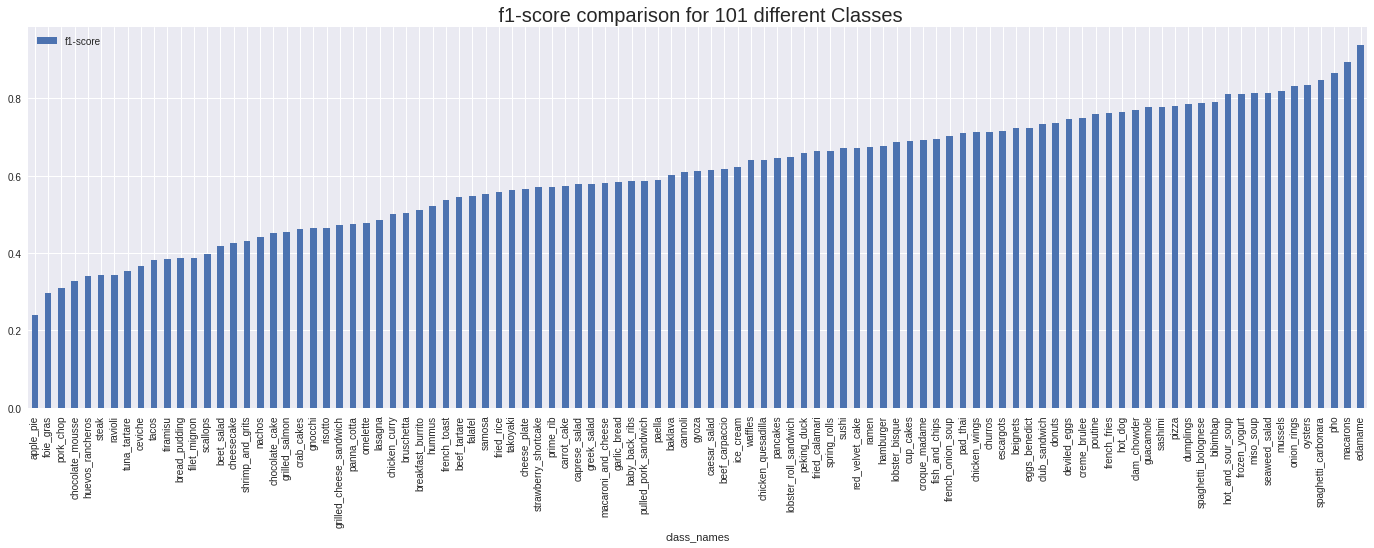

In [ ]:
fig = df.sort_values(by=["f1-score"]).plot(kind="bar", 
                                          figsize=(24, 7), 
                                          title=" f1-score comparison for 101 different Classes")

fig.axes.title.set_size(20);

## Loading and predicting on the real-world food images

Let's now deploy our model to predict the labels for the real world food images.

We'll need to preprocess the image before passing it to the model for prediction. 

So, we'll create a function `load_and_prep_images` which will read the image, convert it into a tensor, reshapes the obtained tensor and finally scale it if required.

In [ ]:
# Function to load and preprocess the image
def load_and_prep_images(filename, image_shape=IMG_SIZE, scale=True):
  '''
  Reads in an image from the given filename, converts it into tensor and
  reshapes it into the specified shape(image_shape, image_shape, color_channels=3).

  Args:
    filename (str): path to the target image
    image_shape (int): height/width dimension of the target image
    scale (bool): scale pixel values from 0-255 to 0-1.

  Returns:
    Image tensor of shape (image_shape, image_shape, 3).
  '''
  # Reads in the image
  img = tf.io.read_file(filename=filename)

  # Converts the read in image to a 3-channeled tensor
  img = tf.io.decode_image(img, channels=3)

  # Reshapes the tensor
  img = tf.image.resize(img, size=[image_shape, image_shape])

  # Rescales the image
  if scale:
    return img/255.
  else:
    return img  # Rescaling is in-built in certain models like EfficientNet models 

Now we've got a function to load and prepare target image, let's visualize the image, their target label and model's predictions.

In [ ]:
def load_predict_plot_image():
  plt.figure(figsize=(20, 7))
  for i in range(5):
    random_class = random.choice(class_names)
    random_class_path = test_dir + "/" + random_class
    random_image = random.choice(os.listdir(random_class_path))
    random_image_path = random_class_path + "/" + random_image

    # print(random_image_path)
    img = load_and_prep_image(random_image_path, scale=False) # scale=False because we're using EfficientNet model
    img_expanded = tf.expand_dims(img, axis=0)
    preds = model.predict(img_expanded)
    pred_prob = np.max(preds)
    pred_class = class_names[preds.argmax()]
    # print(pred_class, pred_prob)

    plt.subplot(1, 5, i+1)
    plt.imshow(img/255.)
    if random_class == pred_class:
      title_color = 'g'
    else:
      title_color = 'r'
    plt.title(f"Actual: {random_class}\nPred: {pred_class}\nProb: {pred_prob:.2f}", c=title_color)
    plt.axis(False) 

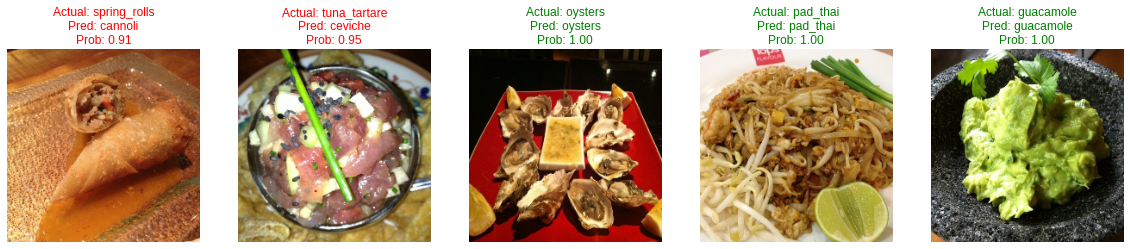

In [ ]:
load_predict_plot_image()

## Finding the most wrong predictions
To find out where model is going wrong, let's visualize the images and check them for ourselves what is probably happening:

1. Get all the images file paths and create a using tf's `list_files()`.
2. Create a pandas dataframe of image filepaths, actual_class, predicted_class, prediction confidence(max. pred prob).
3. Use our dataframe to find all the wrong predictions (where actual_label != pred_label).
4. Sort the wrong predictions in the descending order of prediction_confidence.
5. Visualize the images with the highest prediction probabilities but have the wrong prediction.


In [ ]:
filepaths = []
for filepath in test_data.list_files("/content/101_food_classes_10_percent/test/*/*.jpg", 
                                       shuffle=False):
  filepaths.append(filepath.numpy())

In [ ]:
filepaths[:10]

[b'/content/101_food_classes_10_percent/test/apple_pie/1011328.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/101251.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1034399.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/103801.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1038694.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1047447.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1068632.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/110043.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1106961.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1113017.jpg']

In [ ]:
len(filepaths)

25250

In [ ]:
len([max(i) for i in preds_probs])

25250

In [ ]:
# Creating dataframe of filepaths, pred_prob, actual_class, pred_class, 
df_test_images = pd.DataFrame({"image_path": filepaths,
                               "y_true": y_labels,
                               "y_pred": pred_classes,
                               "pred_prob": preds_probs.max(axis=1),
                               "actual_class": [class_names[i] for i in y_labels],
                               "pred_class": [class_names[i] for i in pred_classes]})
df_test_images.head(10)

,image_path,y_true,y_pred,pred_prob,actual_class,pred_class
0,b'/content/101_food_classes_10_percent/test/ap...,0,52,0.847419,apple_pie,gyoza
1,b'/content/101_food_classes_10_percent/test/ap...,0,0,0.964017,apple_pie,apple_pie
2,b'/content/101_food_classes_10_percent/test/ap...,0,0,0.959259,apple_pie,apple_pie
3,b'/content/101_food_classes_10_percent/test/ap...,0,80,0.658607,apple_pie,pulled_pork_sandwich
4,b'/content/101_food_classes_10_percent/test/ap...,0,79,0.367902,apple_pie,prime_rib
5,b'/content/101_food_classes_10_percent/test/ap...,0,61,0.456753,apple_pie,lobster_roll_sandwich
6,b'/content/101_food_classes_10_percent/test/ap...,0,29,0.611243,apple_pie,cup_cakes
7,b'/content/101_food_classes_10_percent/test/ap...,0,0,0.473133,apple_pie,apple_pie
8,b'/content/101_food_classes_10_percent/test/ap...,0,85,0.245396,apple_pie,samosa
9,b'/content/101_food_classes_10_percent/test/ap...,0,0,0.724390,apple_pie,apple_pie


In [ ]:
# Adding a column to the dataset where actual and prediction labels are not same
df_test_images["pred_correct"] = df_test_images.y_true == df_test_images.y_pred
df_test_images[:10]

,image_path,y_true,y_pred,pred_prob,actual_class,pred_class,pred_correct
0,b'/content/101_food_classes_10_percent/test/ap...,0,52,0.847419,apple_pie,gyoza,False
1,b'/content/101_food_classes_10_percent/test/ap...,0,0,0.964017,apple_pie,apple_pie,True
2,b'/content/101_food_classes_10_percent/test/ap...,0,0,0.959259,apple_pie,apple_pie,True
3,b'/content/101_food_classes_10_percent/test/ap...,0,80,0.658607,apple_pie,pulled_pork_sandwich,False
4,b'/content/101_food_classes_10_percent/test/ap...,0,79,0.367902,apple_pie,prime_rib,False
5,b'/content/101_food_classes_10_percent/test/ap...,0,61,0.456753,apple_pie,lobster_roll_sandwich,False
6,b'/content/101_food_classes_10_percent/test/ap...,0,29,0.611243,apple_pie,cup_cakes,False
7,b'/content/101_food_classes_10_percent/test/ap...,0,0,0.473133,apple_pie,apple_pie,True
8,b'/content/101_food_classes_10_percent/test/ap...,0,85,0.245396,apple_pie,samosa,False
9,b'/content/101_food_classes_10_percent/test/ap...,0,0,0.724390,apple_pie,apple_pie,True


In [ ]:
# Filtering out the top 100 wrong predictions in descending order
df_top_100_wrong = df_test_images[df_test_images.pred_correct == False].sort_values(by=["pred_prob"], ascending=False, inplace=True)[:100]
df_top_100_wrong

,image_path,y_true,y_pred,pred_prob,actual_class,pred_class,pred_correct
21810,b'/content/101_food_classes_10_percent/test/sc...,87,29,0.999997,scallops,cup_cakes,False
231,b'/content/101_food_classes_10_percent/test/ap...,0,100,0.999995,apple_pie,waffles,False
15359,b'/content/101_food_classes_10_percent/test/lo...,61,53,0.999988,lobster_roll_sandwich,hamburger,False
23539,b'/content/101_food_classes_10_percent/test/st...,94,83,0.999987,strawberry_shortcake,red_velvet_cake,False
21400,b'/content/101_food_classes_10_percent/test/sa...,85,92,0.999981,samosa,spring_rolls,False
...,...,...,...,...,...,...,...
8763,b'/content/101_food_classes_10_percent/test/es...,35,41,0.997169,escargots,french_onion_soup,False
2663,b'/content/101_food_classes_10_percent/test/br...,10,61,0.997055,bruschetta,lobster_roll_sandwich,False
7924,b'/content/101_food_classes_10_percent/test/do...,31,29,0.997020,donuts,cup_cakes,False
18586,b'/content/101_food_classes_10_percent/test/pe...,74,39,0.996885,peking_duck,foie_gras,False


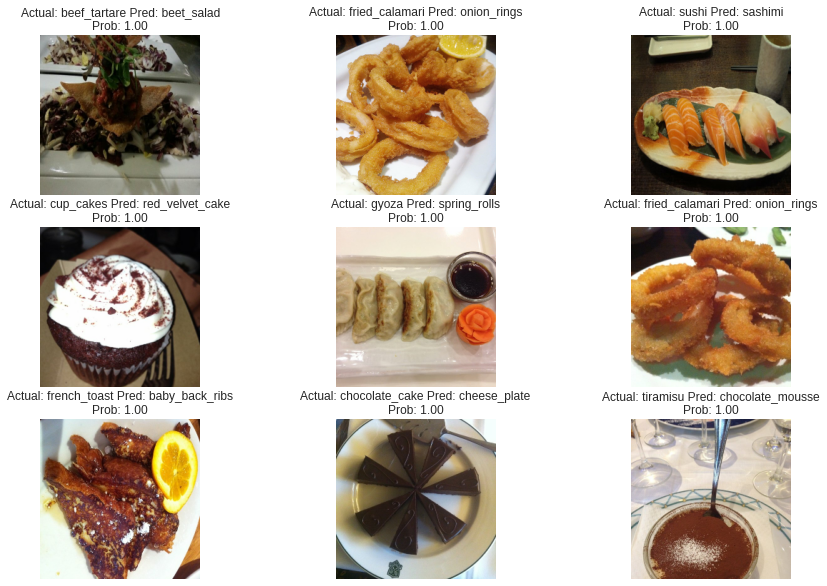

In [ ]:
# Let's visualize the wrong images
starting_index = 14
no_of_images = 9

plt.figure(figsize=(15, 10))
for i, row in enumerate(df_top_100_wrong[starting_index:starting_index+no_of_images].itertuples()):
  plt.subplot(3, 3, i+1)
  
  img = load_and_prep_image(row[1], scale=False)
  _, _, _, _, pred_conf, true_label, pred_label, _ = row

  plt.imshow(img/255.)
  plt.title(f"Actual: {true_label} Pred: {pred_label}\nProb: {pred_conf:.2f}")
  plt.axis(False)

## Final prediction on my own images 😁

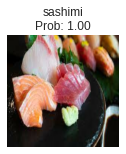

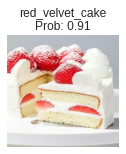

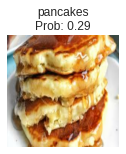

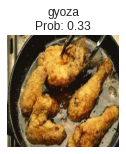

In [ ]:
image_dir = "/content/drive/MyDrive/Documents"
images =os.listdir("/content/drive/MyDrive/Documents")
image_path = [(image_dir+"/"+i) for i in images]
for path in image_path:
  img = load_and_prep_image(path, scale=False)
  pred_prob = model.predict(tf.expand_dims(img, axis=0))
  pred_label = class_names[pred_prob.argmax()]
  
  plt.figure(figsize=(2, 3))
  plt.imshow(img/255.)
  plt.title(f"{pred_label}\nProb: {pred_prob.max():.2f}")
  plt.axis(False)